<a href="https://colab.research.google.com/github/Kamruzzaman2200/Ai/blob/main/k_Fold_D2_dataset_imprv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install libraries

In [4]:
!pip install imblearn boruta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 3.5 MB/s eta 0:00:00


#Imports

In [5]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data & preprocessing
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

# Feature engineering
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import RFE
from boruta import BorutaPy

# Estimators for RFE/Boruta
from sklearn.ensemble import RandomForestClassifier

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import make_scorer, accuracy_score

#Load dataset

In [6]:
# Path to the uploaded file
file_path = "/content/drive/MyDrive/DataSets/dataset-2_9.csv"   # <-- updated to your uploaded file

df = pd.read_csv(file_path)
print("✅ Dataset loaded:", file_path)
print("\n--- Shape ---")
print(df.shape)
print("\n--- Columns ---")
print(df.columns.tolist())
print("\n--- First 5 rows ---")
print(df.head())
print("\n--- Info ---")
df.info()


✅ Dataset loaded: /content/drive/MyDrive/DataSets/dataset-2_9.csv

--- Shape ---
(672, 55)

--- Columns ---
['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'UCLA1', 'UCLA2', 'UCLA3', 'UCLA4', 'UCLA5', 'UCLA6', 'UCLA7', 'UCLA8', 'PHQ1', 'PHQ2', 'PHQ3', 'PHQ4', 'PHQ5', 'PHQ6', 'PHQ7', 'PHQ8', 'PHQ9', 'Sum_PHQ', 'Depression', 'GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 'PSQI1', 'PSQI2', 'PSQI3', 'PSQI4', 'PSQI5', 'PSQI6', 'PSQI7', 'PSQI8', 'PSQI9', 'PSQI10', 'PSQI11', 'PSQI12', 'PSQI13', 'PSQI14', 'PSQI15', 'PSQI16', 'PSQI17', 'PSQI18', 'PSQI19']

--- First 5 rows ---
         D1      D2          D3         D4                D5          D6  \
0     15-30    Male  Overweight    Married  Higher secondary  Unemployed   
1  Above 30    Male      Normal    Married        Illiterate  Unemployed   
2  Above 30  Female      Normal  Unmarried           Primary  Unemployed   
3  Above 30  Female      Normal    Married    Graduate/above     Student   
4  Above 30    Male   

#Define target + encoding

In [7]:
# Define the target column
target = 'Depression'

# Normalize all column names to lowercase and strip spaces
df.columns = df.columns.str.strip().str.lower()

# Match target with normalized column names
target = target.strip().lower()

# Encode the target column
if target in df.columns:
    df[target] = LabelEncoder().fit_transform(df[target].astype(str))
    print(f"✅ Target column '{target}' encoded.")
else:
    print(f"❌ ERROR: Target column '{target}' not found in the dataset!")

# Encode other categorical columns
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = LabelEncoder().fit_transform(df[col].astype(str))
        except:
            print(f"Could not automatically encode column: {col}")

print("\n✅ Cleaned and encoded dataset:")
print(df.head())
df.info()


✅ Target column 'depression' encoded.

✅ Cleaned and encoded dataset:
   d1  d2  d3  d4  d5  d6  d7  d8  d9  d10  ...  psqi10  psqi11  psqi12  \
0   0   1   1   0   1   3   0   1   1    0  ...       0       3       1   
1   1   1   0   0   2   3   1   0   0    1  ...       0       1       1   
2   1   0   0   1   3   3   2   0   0    0  ...       2       0       3   
3   1   0   0   0   0   2   2   0   0    0  ...       1       1       0   
4   1   1   0   0   0   2   2   0   0    0  ...       1       0       2   

   psqi13  psqi14  psqi15  psqi16  psqi17  psqi18  psqi19  
0       0       0       0       0       0       2       2  
1       2       3       3       0       0       0       1  
2       1       0       1       0       0       0       2  
3       1       1       2       0       0       0       1  
4       1       1       2       0       1       0       2  

[5 rows x 55 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 55 c

#Class distribution plot

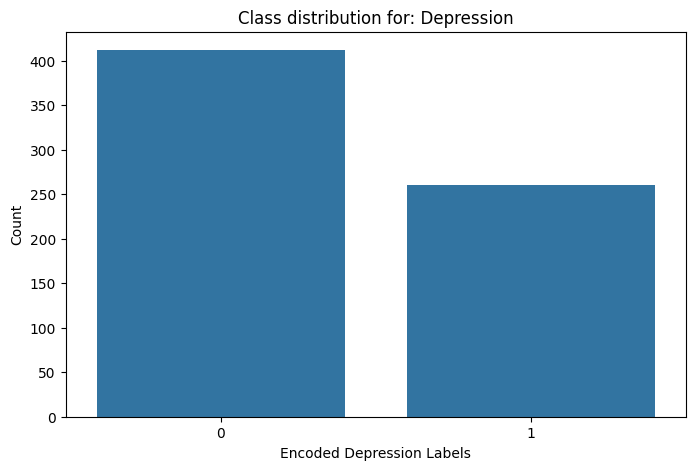

depression
0    0.613095
1    0.386905
Name: proportion, dtype: float64


In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(x=target, data=df)
plt.title(f'Class distribution for: Depression')
plt.xlabel('Encoded Depression Labels')
plt.ylabel('Count')
plt.show()

print(df[target].value_counts(normalize=True).rename('proportion'))


#Correlation heatmap

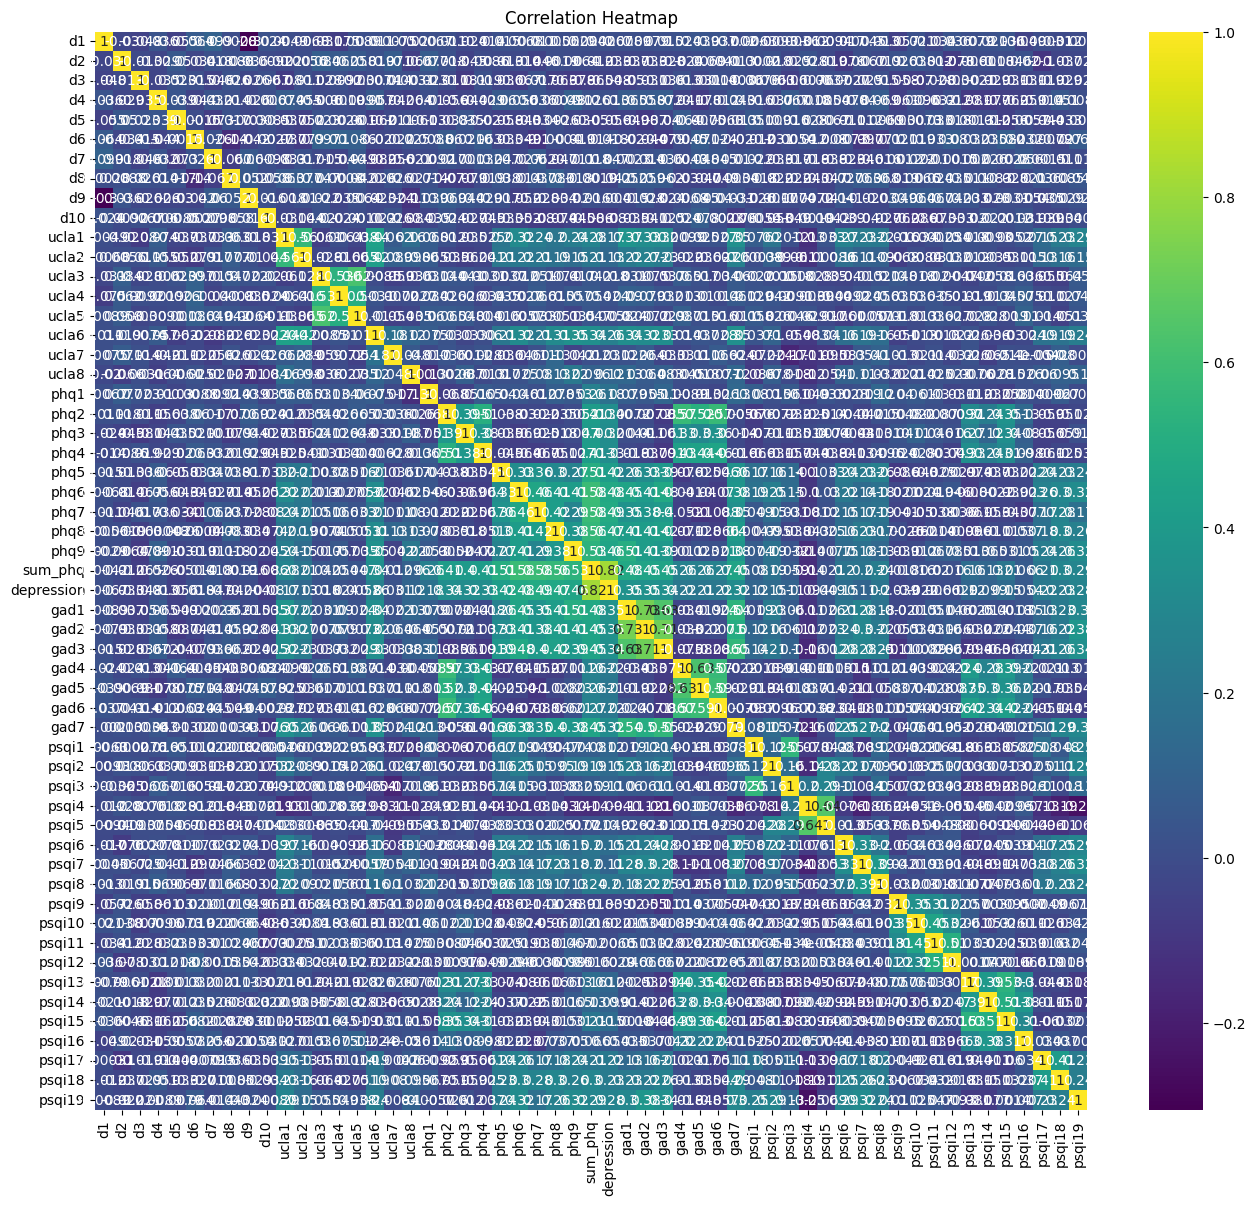

In [9]:
plt.figure(figsize=(16, 14))
sns.heatmap(df.corr(numeric_only=True), cmap='viridis', annot=True)
plt.title('Correlation Heatmap')
plt.show()

#t-SNE Visualization

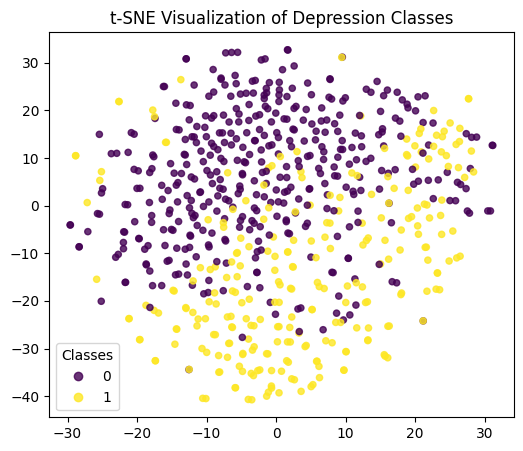

In [10]:
from sklearn.manifold import TSNE

if target in df.columns:
    X_vis = df.drop(columns=[target])
    y_vis = df[target]

    X_vis_scaled = StandardScaler().fit_transform(X_vis)

    tsne = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto',
                perplexity=min(30, len(df)-1))
    X2 = tsne.fit_transform(X_vis_scaled)

    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(X2[:, 0], X2[:, 1], c=y_vis, s=20, alpha=0.8, cmap='viridis')
    plt.title('t-SNE Visualization of Depression Classes')
    plt.legend(handles=scatter.legend_elements()[0],
               labels=list(np.unique(y_vis)),
               title="Classes")
    plt.show()


#Features and Target split

In [11]:
X = df.drop(columns=[target])
y = df[target].astype(int)

print("X shape:", X.shape, "| y values:", y.unique())


X shape: (672, 54) | y values: [0 1]


#CV & Scoring

In [12]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
scoring = {'accuracy': make_scorer(accuracy_score)}


#Scalers & Classifiers

In [13]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVM (RBF)": SVC(kernel='rbf', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
}


#Feature Selection Blocks

In [14]:
def pca_block():
    return ('pca', PCA(n_components=0.95, random_state=42))

def lda_block():
    return ('lda', LDA(solver='svd'))

def rfe_block():
    base = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    return ('rfe', RFE(estimator=base, n_features_to_select=10, step=1))

def boruta_block():
    base = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1, class_weight='balanced')

    class BorutaWrapper(BorutaPy):
        def transform(self, X, y=None):
            return super().transform(X)

        def fit_transform(self, X, y=None, **fit_params):
            return super().fit(X, y).transform(X)

    return ('boruta', BorutaWrapper(estimator=base, n_estimators='auto',
                                    verbose=0, random_state=42, max_iter=50))


#Feature Methods Dictionary

In [15]:
feature_methods = {
    "All Features": [],
    "PCA": [pca_block()],
    "LDA": [lda_block()],
    "RFE": [rfe_block()],
    "Boruta": [boruta_block()]
}


#Model Training & Evaluation

In [16]:
results = []

for scaler_name, scaler in scalers.items():
    for method_name, method_steps in feature_methods.items():
        for clf_name, clf in classifiers.items():

            steps = [('scaler', scaler)]

            if method_name != 'LDA':
                steps.append(('smote', SMOTE(random_state=42)))

            steps.extend(method_steps)
            steps.append(('clf', clf))

            pipe = Pipeline(steps)

            try:
                cv_out = cross_validate(
                    pipe, X.values, y.values,
                    cv=cv,
                    scoring=scoring,
                    return_train_score=False,
                    n_jobs=-1
                )

                fold_scores = cv_out['test_accuracy']

                results.append({
                    'Scaler': scaler_name,
                    'Method': method_name,
                    'Classifier': clf_name,
                    'Fold_Scores': fold_scores,
                    'Mean_Accuracy': float(np.mean(fold_scores)),
                    'Std_Accuracy': float(np.std(fold_scores, ddof=1))
                })
                print(f"Finished: {scaler_name} | {method_name} | {clf_name}")

            except Exception as e:
                print(f"FAILED: {scaler_name} | {method_name} | {clf_name} with error: {e}")

results_df = pd.DataFrame(results).sort_values('Mean_Accuracy', ascending=False).reset_index(drop=True)
print("\n✅ Done evaluating all combinations.")
results_df[['Scaler','Method','Classifier','Mean_Accuracy','Std_Accuracy']].head(10)


Finished: StandardScaler | All Features | Logistic Regression
Finished: StandardScaler | All Features | KNN
Finished: StandardScaler | All Features | SVM (RBF)
Finished: StandardScaler | All Features | Random Forest
Finished: StandardScaler | PCA | Logistic Regression
Finished: StandardScaler | PCA | KNN
Finished: StandardScaler | PCA | SVM (RBF)
Finished: StandardScaler | PCA | Random Forest
Finished: StandardScaler | LDA | Logistic Regression
Finished: StandardScaler | LDA | KNN
Finished: StandardScaler | LDA | SVM (RBF)
Finished: StandardScaler | LDA | Random Forest
Finished: StandardScaler | RFE | Logistic Regression
Finished: StandardScaler | RFE | KNN
Finished: StandardScaler | RFE | SVM (RBF)
Finished: StandardScaler | RFE | Random Forest
Finished: StandardScaler | Boruta | Logistic Regression
Finished: StandardScaler | Boruta | KNN
Finished: StandardScaler | Boruta | SVM (RBF)
Finished: StandardScaler | Boruta | Random Forest
Finished: MinMaxScaler | All Features | Logistic Reg

,Scaler,Method,Classifier,Mean_Accuracy,Std_Accuracy
0,StandardScaler,All Features,Random Forest,1.000000,0.000000
1,MinMaxScaler,All Features,Random Forest,1.000000,0.000000
2,StandardScaler,Boruta,Random Forest,1.000000,0.000000
3,StandardScaler,RFE,Random Forest,1.000000,0.000000
4,RobustScaler,Boruta,Random Forest,1.000000,0.000000
5,RobustScaler,All Features,Random Forest,1.000000,0.000000
6,MinMaxScaler,Boruta,Random Forest,1.000000,0.000000
7,RobustScaler,RFE,Random Forest,1.000000,0.000000
8,MinMaxScaler,RFE,Random Forest,1.000000,0.000000
9,StandardScaler,Boruta,Logistic Regression,0.998515,0.003075


#Results Table

In [17]:
disp = results_df.copy()
disp['Accuracy (mean ± std)'] = (disp['Mean_Accuracy']*100).round(2).astype(str) + \
                                 '% ± ' + (disp['Std_Accuracy']*100).round(2).astype(str) + '%'

cols = ['Scaler', 'Method', 'Classifier', 'Accuracy (mean ± std)', 'Mean_Accuracy']
disp_table = disp[cols].sort_values(by='Mean_Accuracy', ascending=False).drop(columns=['Mean_Accuracy'])

print("--- 🏆 Final Accuracy (mean ± std) ---")
print(disp_table.to_string(index=False))


--- 🏆 Final Accuracy (mean ± std) ---
        Scaler       Method          Classifier Accuracy (mean ± std)
StandardScaler All Features       Random Forest         100.0% ± 0.0%
  MinMaxScaler All Features       Random Forest         100.0% ± 0.0%
StandardScaler       Boruta       Random Forest         100.0% ± 0.0%
StandardScaler          RFE       Random Forest         100.0% ± 0.0%
  RobustScaler       Boruta       Random Forest         100.0% ± 0.0%
  RobustScaler All Features       Random Forest         100.0% ± 0.0%
  MinMaxScaler       Boruta       Random Forest         100.0% ± 0.0%
  RobustScaler          RFE       Random Forest         100.0% ± 0.0%
  MinMaxScaler          RFE       Random Forest         100.0% ± 0.0%
StandardScaler       Boruta Logistic Regression        99.85% ± 0.31%
  RobustScaler       Boruta Logistic Regression        99.06% ± 1.33%
StandardScaler          RFE Logistic Regression        97.92% ± 1.35%
  MinMaxScaler       Boruta Logistic Regression     

#Plot Top N Results

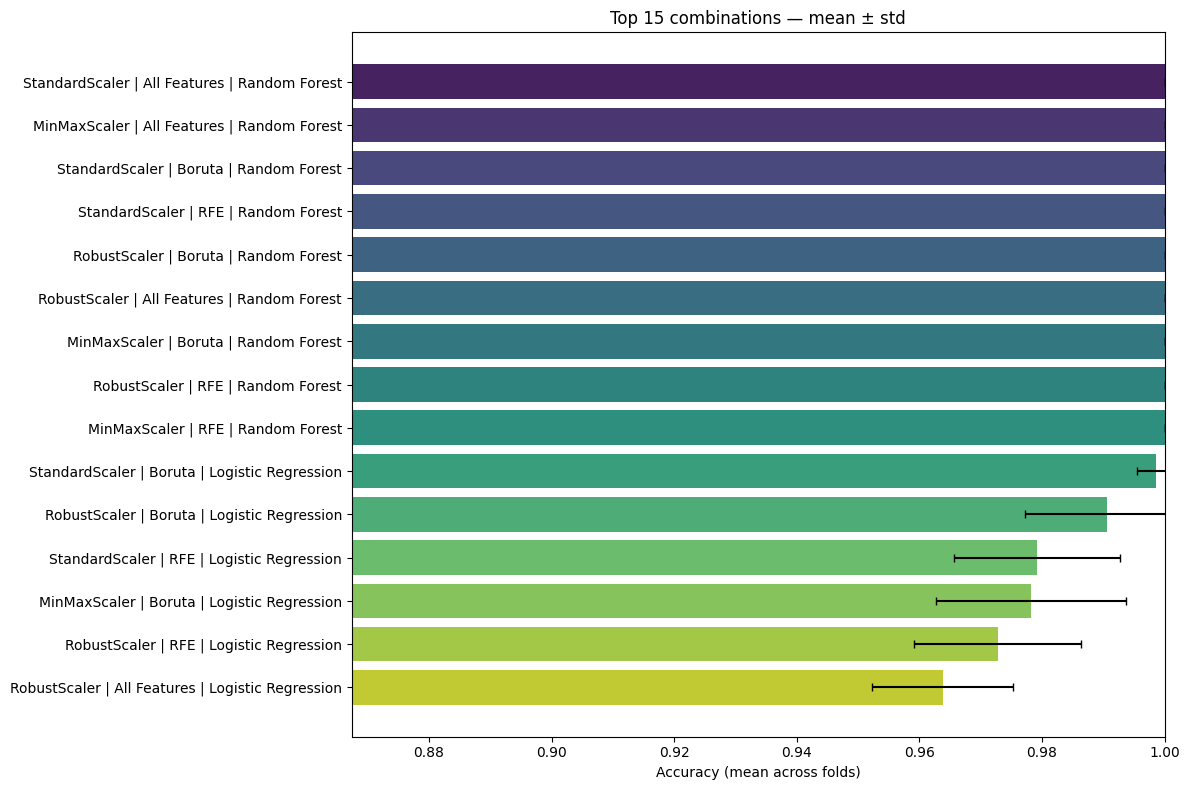

In [18]:
top_n = 15
plot_df = results_df.head(top_n).copy()
plot_df['label'] = plot_df['Scaler'] + ' | ' + plot_df['Method'] + ' | ' + plot_df['Classifier']

plt.figure(figsize=(12, 8))
ax = sns.barplot(
    data=plot_df,
    y='label', x='Mean_Accuracy',
    palette='viridis'
)

ax.errorbar(
    x=plot_df['Mean_Accuracy'],
    y=np.arange(len(plot_df)),
    xerr=plot_df['Std_Accuracy'],
    fmt='none',
    c='black',
    capsize=3
)

plt.xlim(left=plot_df['Mean_Accuracy'].min() * 0.9, right=1.0)
plt.xlabel('Accuracy (mean across folds)')
plt.ylabel('')
plt.title(f'Top {top_n} combinations — mean ± std')
plt.tight_layout()
plt.show()
